# PASOS PARA REALIZAR UN MODELO ARIMA

1. Preparación de datos:
2. Comprobar si la serie es estacionaria:
3. División de datos:
4. Construcción del modelo ARIMA:
5. Realización de la predicción:
6. Visualización de la predicción:

## Importar librerías necesarias

In [3]:
import numpy as np
import pandas as pd

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.arima_model import ARIMA
# from pmdarima import ARIMA

warnings.filterwarnings("ignore")

## 1. Preparación de los datos

* Importar los datos
* Asegurar que existe una columna 'FECHA' y una columna 'ICA'
* Asegurar que la columna 'FECHA' tiene formato datetime
* Establecer la fecha como índice del dataframe

In [4]:
df = pd.read_csv('../data/calidad_aire_clean_outliers.csv', delimiter=',')
df = df[['FECHA', 'NO2']]
df["FECHA"] = pd.to_datetime(df["FECHA"], format="%Y-%m-%d %H:%M:%S")
df.set_index("FECHA", inplace = True)
df.dropna(inplace = True, axis = "rows")
df.head(2)

,NO2
FECHA,
2019-01-01 05:00:00,50.0
2019-01-01 06:00:00,55.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30860 entries, 2019-01-01 05:00:00 to 2023-05-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NO2     30860 non-null  float64
dtypes: float64(1)
memory usage: 482.2 KB


## 2. Comprobar si la serie es estacionaria

#### 2.1. Visualización: Análisis exploratorio de datos (EDA)

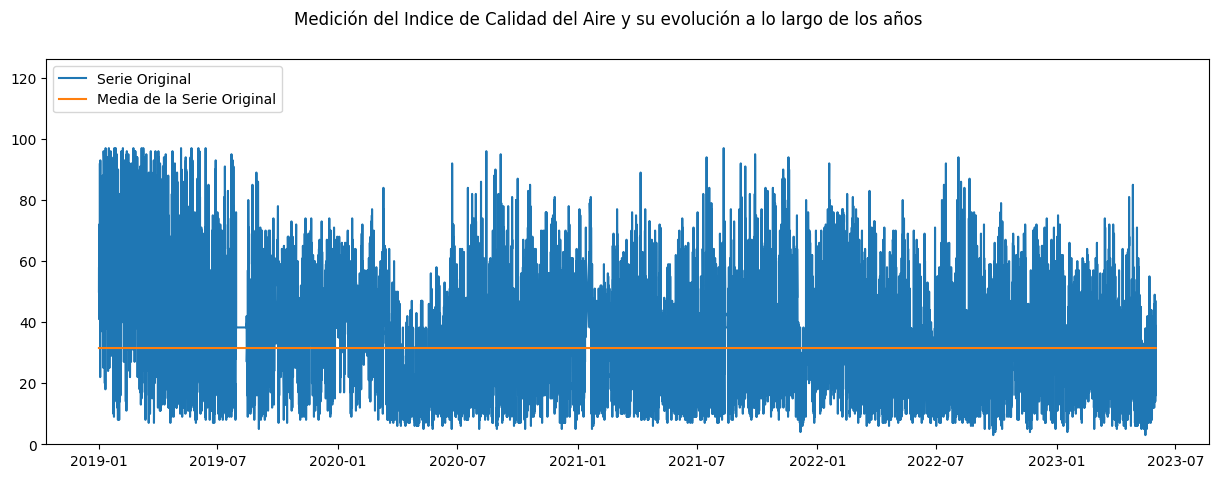

In [6]:
# separar x y la y para el gráfico
x = df.index

y = df["NO2"]
y_media = [np.mean(y) for _ in y]

# visualización de los datos anteriores a los largo de los años
fig = plt.figure(figsize = (15, 5))
ax = fig.subplots(1, 1)

# la serie original parece ser estacionaria si nos fijamos en su comportamiento, ya que la media es la misma en 
# tramos diferentes de la serie.
ax.plot(x, y, label = "Serie Original")
ax.plot(x, y_media, label = "Media de la Serie Original")
ax.set_ylim(0, np.max(y)*1.3)
ax.legend(loc = "upper left")
fig.suptitle("Medición del Indice de Calidad del Aire y su evolución a lo largo de los años");

#### 2.2. Prueba estadística ADF: Comprobación de la estacionaridad de la serie 

* El objetivo de la prueba ADF es evaluar la presencia de una raíz unitaria en una serie temporal, lo que indica la presencia de tendencia y no  
  estacionariedad.

* La hipótesis nula (H0) de la prueba ADF es que la serie temporal tiene una raíz unitaria, lo que significa que es no estacionaria. 

* La hipótesis alternativa (H1) es que la serie no tiene una raíz unitaria y, por lo tanto, es estacionaria.

* El estadístico ADF se calcula comparando la tasa de cambio en los valores de la serie temporal con su propia variación aleatoria:
  - Si el estadístico ADF es menor que el valor crítico (umbral), se rechaza la hipótesis nula y se concluye que la serie es estacionaria. 
  - Si el estadístico ADF es mayor que el valor crítico, no se puede rechazar la hipótesis nula y se concluye que la serie es no estacionaria.

In [7]:
for serie, nombre_serie in zip([y], ["Serie Original"]):    
    resultado_analisis = adfuller(serie)
    
    valor_estadistico_adf = resultado_analisis[0]
    p_valor = resultado_analisis[1]
    
    print("Valor estadístico de ADF: {}".format(-2.89))
    print("Valor Crítico: {}\n".format(valor_estadistico_adf))
    
    print("Nivel de significación: {}".format(0.05))
    print("p-valor: {}\n".format(p_valor))

Valor estadístico de ADF: -2.89
Valor Crítico: -13.551911412917372

Nivel de significación: 0.05
p-valor: 2.4003365236628887e-25



* ADF: Decisión a partir del resultado obtenido:

 1. Observamos p-valor < nivel significación, es decir, el estadístico ADF es menor que el valor crítico. 
 2. Por tanto, rechazamos la hipótesis nula (H0). 
 3. Conclusión:
    * LA SERIE ES ESTACIONARIA

#### 2.3.  Analizar autocorrelación y autocorrelación parcial

* LAGS: Desfases o rezagos en una serie temporal. Representan la diferencia de tiempo entre una observación y otra. 
  Por ejemplo, un lag de 1 indica la correlación entre una observación y la observación inmediatamente anterior.

* ACF (Autocorrelación): La función de autocorrelación (ACF, por sus siglas en inglés) es una medida de la correlación entre una observación 
  y sus valores rezagados a diferentes intervalos de tiempo. Representa cómo se correlaciona una serie consigo misma a medida que se desplaza en el tiempo. La ACF se utiliza para identificar patrones de correlación en una serie temporal.

* PACF (Autocorrelación parcial): La función de autocorrelación parcial (PACF, por sus siglas en inglés) mide la correlación directa entre una 
  observación y sus valores rezagados, eliminando la influencia de los valores intermedios. La PACF ayuda a determinar la correlación directa entre una observación y su rezago específico, ignorando las correlaciones indirectas.

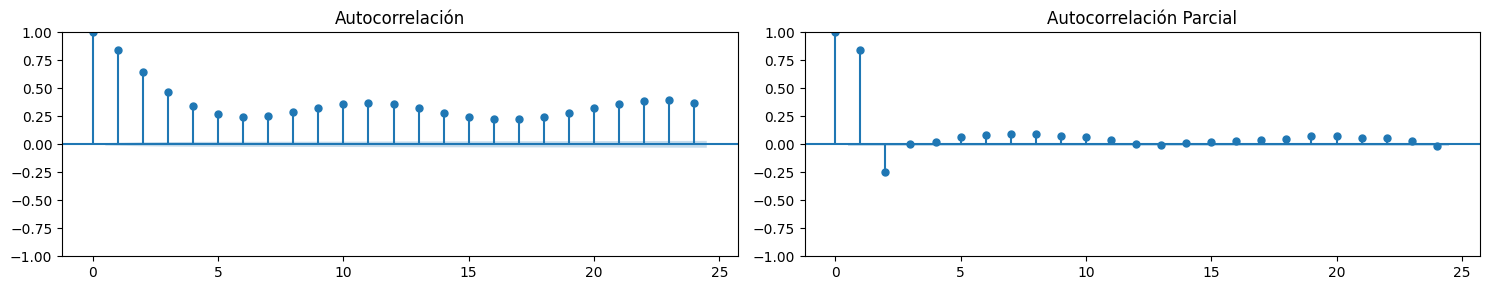

In [8]:
LAGS = 24

fig = plt.figure(figsize = (15, 3))
(ax1, ax2) = fig.subplots(1, 2)

# Gráfico de ACF(autocorrelación) y PACF(Autocorrelación Parcial)
plot_acf(y, ax = ax1, lags = LAGS, title = "Autocorrelación")
plot_pacf(y, ax = ax2, lags = LAGS, title = "Autocorrelación Parcial")

fig.tight_layout()

## 3. División de datos

* train: Entrenamiento
* test: Prueba

In [9]:
serie_a_predecir = y

# Predecir valor del ICA en los próximos 30 días
y_train = df[:-720]
y_test = df[-720:]

print(y_train.head())
print(y_test.head())

                      NO2
FECHA                    
2019-01-01 05:00:00  50.0
2019-01-01 06:00:00  55.0
2019-01-01 07:00:00  56.0
2019-01-01 08:00:00  58.0
2019-01-01 09:00:00  51.0
                      NO2
FECHA                    
2023-04-29 08:00:00  38.0
2023-04-29 10:00:00  23.0
2023-04-29 12:00:00  41.0
2023-04-29 15:00:00  15.0
2023-04-29 16:00:00  11.0


## 4.  Construcción de Modelo ARIMA

Un modelo ARIMA se repsenta como ARIMA (p, d, q) donde:

* AR (p): representa la parte "Autorregresiva" del modelo. La intuición básica consiste en que los valores pasados más próximos al momento "t", 
  tendrán mayor impacto en los valores presentes. Para determinar el orden "p" del modelo, podemos utilizar el plot de autocorrelación parcial

* I (d): representa la parte "Integral" del modelo y este parámetro del modelo nos dice cuantos diferenciaciones (restas de la serie contra si 
  misma) se tienen que llevar a cabo para convertir la serie en estacionaria.

* MA (q): representa la parte de "Medias Móviles". Como vimos, esto implica que el error del modelo se establece como una combinaciòn lineal de 
  los errores observados en el pasado. Para determinar el orden "q" del modelo, podemos utilizar el plot de autocorrelación.

El modelo básico de ARIMA se puede extender más allá incorporando la estacionalidad de la serie y variables exógenas. En este caso estaríamos hablado del modelo SARIMAX representado por (p, d, q) x (P, D, Q) S: donde los parámetros (P, D, Q) representan la misma idea que los (p, d, q) pero tratan sobre la parte estacional de la serie.

El parámetro S a su vez representa el número de periodos que tienen que pasar para que la estacionalidad se repita: 12 para meses, 4 para trimestres etc.

In [10]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# En caso de querer probar un modelo SARIMAX completo, ejecutar la siguiente línea de itertools.
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Los dejamos a cero para sólo analizar un modelo ARIMA.
seasonal_pdq = [(0, 0, 0, 0)]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 0)
SARIMAX: (0, 1, 0) x (0, 0, 0, 0)


#### 4.1 Gridsearch: Búsqueda de los parámetros óptimos para el modelo ARIMA

A continuación utilizaremos una "Gridsearch" básico para buscar los parámetros óptimos del modelo ARIMA.

* Para hacer el gridsearch, hay que calcular los posibles valores que vamos a pasarle al modelo.

* Utilizamos el modelo SARIMAX, porque en su implementaciòn en Python existen herramientas adicionales  que facilitan el análisis y que
  no están disponibles en la implementación de ARIMA.

* ARIMAX es un modelo ARIMA pero con un componente estacional (la leta S de Seasonal) y también un componente exógeno (X de eXogenous 
  regressors). Por tanto un modelo SARIMAX de (1, 1, 1) x (0, 0, 0, 0). Es un modelo ARIMA (1, 1, 1)   

In [11]:
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # guardamos el mejor resultado
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal   
        # alguna combinación de parámetros en SARIMAX, no son válidos y los vamos a cazar con un except
        except:
            continue

et = time.time()

print("La búsqueda de parámetros no ha llevado {} minutos!".format((et - st)/60))

ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:301939.01462036464
ARIMA(0, 0, 1)x(0, 0, 0, 0)12 - AIC:269170.25918906817
ARIMA(0, 0, 2)x(0, 0, 0, 0)12 - AIC:250405.7906310684
ARIMA(0, 1, 0)x(0, 0, 0, 0)12 - AIC:222669.22046025883
ARIMA(0, 1, 1)x(0, 0, 0, 0)12 - AIC:221866.44017916353
ARIMA(0, 1, 2)x(0, 0, 0, 0)12 - AIC:221729.3619825193
ARIMA(0, 2, 0)x(0, 0, 0, 0)12 - AIC:238743.32268719125
ARIMA(0, 2, 1)x(0, 0, 0, 0)12 - AIC:222667.8311737329
ARIMA(0, 2, 2)x(0, 0, 0, 0)12 - AIC:221864.2857522472
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:222129.02851790466
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:221132.20798565954
ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:221094.89136531483
ARIMA(1, 1, 0)x(0, 0, 0, 0)12 - AIC:222008.3983687827
ARIMA(1, 1, 1)x(0, 0, 0, 0)12 - AIC:221818.16245412652
ARIMA(1, 1, 2)x(0, 0, 0, 0)12 - AIC:217663.46488726838
ARIMA(1, 2, 0)x(0, 0, 0, 0)12 - AIC:234578.28471382105
ARIMA(1, 2, 1)x(0, 0, 0, 0)12 - AIC:222007.2675972706
ARIMA(1, 2, 2)x(0, 0, 0, 0)12 - AIC:221815.94040741306
ARIMA(2, 0, 0)x(

#### 4.2 Elección del mejor modelo ARIMA:

* El índice de AIC es Akaike Information Criterion y sirve para elegir un modelo entre un conjunto de posibles modelos.

* El índice calcula la distancia de Kullback - Leibler entre el modelo y la serie.

* Una forma de interpretar el índice es: buscamos el modelo con el menor índice porque este es el más simple que se ajusta a los datos.

In [12]:
print("El mejor modelo es {}, \nCon un AIC de {}".format(best_params, best_score))

El mejor modelo es (2, 1, 2), 
Con un AIC de 217189.39230544562


#### 4.3 Entrenamiento del modelo ARIMA

In [13]:
# Entrenamos el modelo con los mejores parametros.

model = sm.tsa.statespace.SARIMAX(y_train,
                                order = best_params,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = model.fit()

#### 4.4 Interpretación del mejor modelo

* Coeficientes: Los coeficientes estimados representan los valores estimados para los parámetros del modelo ARIMA. En tu caso, los coeficientes están etiquetados como ar.L1, ar.L2, ma.L1, ma.L2 y sigma2. Estos coeficientes indican la contribución de las observaciones rezagadas (AR) y los errores rezagados (MA) en la predicción de la serie temporal. Por ejemplo, ar.L1 tiene un valor estimado de 1.3465, lo que significa que la observación actual está positivamente correlacionada con la observación anterior rezagada en un paso de tiempo. Los coeficientes negativos, como ar.L2 y ma.L1, indican correlaciones negativas.

* Errores estándar (std err): Los errores estándar asociados con los coeficientes estimados indican la incertidumbre en las estimaciones de los parámetros del modelo.

* Estadística z y p-valores: Estos valores se utilizan para probar la significancia estadística de los coeficientes. La estadística z es una medida de cuántas desviaciones estándar está el coeficiente del valor nulo. El p-valor indica la probabilidad de obtener una estadística z igual o más extrema que la observada si la hipótesis nula es verdadera. En tu caso, todos los p-valores son muy pequeños (0.000), lo que sugiere que los coeficientes son significativamente diferentes de cero y tienen un impacto significativo en el modelo.

* Intervalos de confianza (0.025 y 0.975): Estos intervalos indican el rango de valores dentro del cual se espera que estén los coeficientes con una confianza del 95%. Por ejemplo, para ar.L1, se espera que el valor real del coeficiente esté dentro del rango de 1.308 a 1.385 con un 95% de confianza.

* Sigma2: Sigma2 representa la varianza estimada del ruido en el modelo ARIMA. Es un parámetro importante para evaluar la calidad del ajuste del modelo. En tu caso, el valor estimado de sigma2 es 33.8653.

En resumen, los coeficientes estimados y los resultados de la prueba de significancia te proporcionan información sobre cómo las observaciones y los errores rezagados contribuyen a la predicción de la serie temporal. Los p-valores bajos y los intervalos de confianza estrechos indican la importancia y la precisión de los coeficientes. Además, el valor de sigma2 te da una idea de la varianza del ruido en el modelo ajustado.

In [14]:
results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2526      0.014     87.031      0.000       1.224       1.281
ar.L2         -0.4891      0.012    -41.826      0.000      -0.512      -0.466
ma.L1         -1.2440      0.016    -79.469      0.000      -1.275      -1.213
ma.L2          0.2713      0.015     17.555      0.000       0.241       0.302
sigma2        78.9395      0.386    204.303      0.000      78.182      79.697


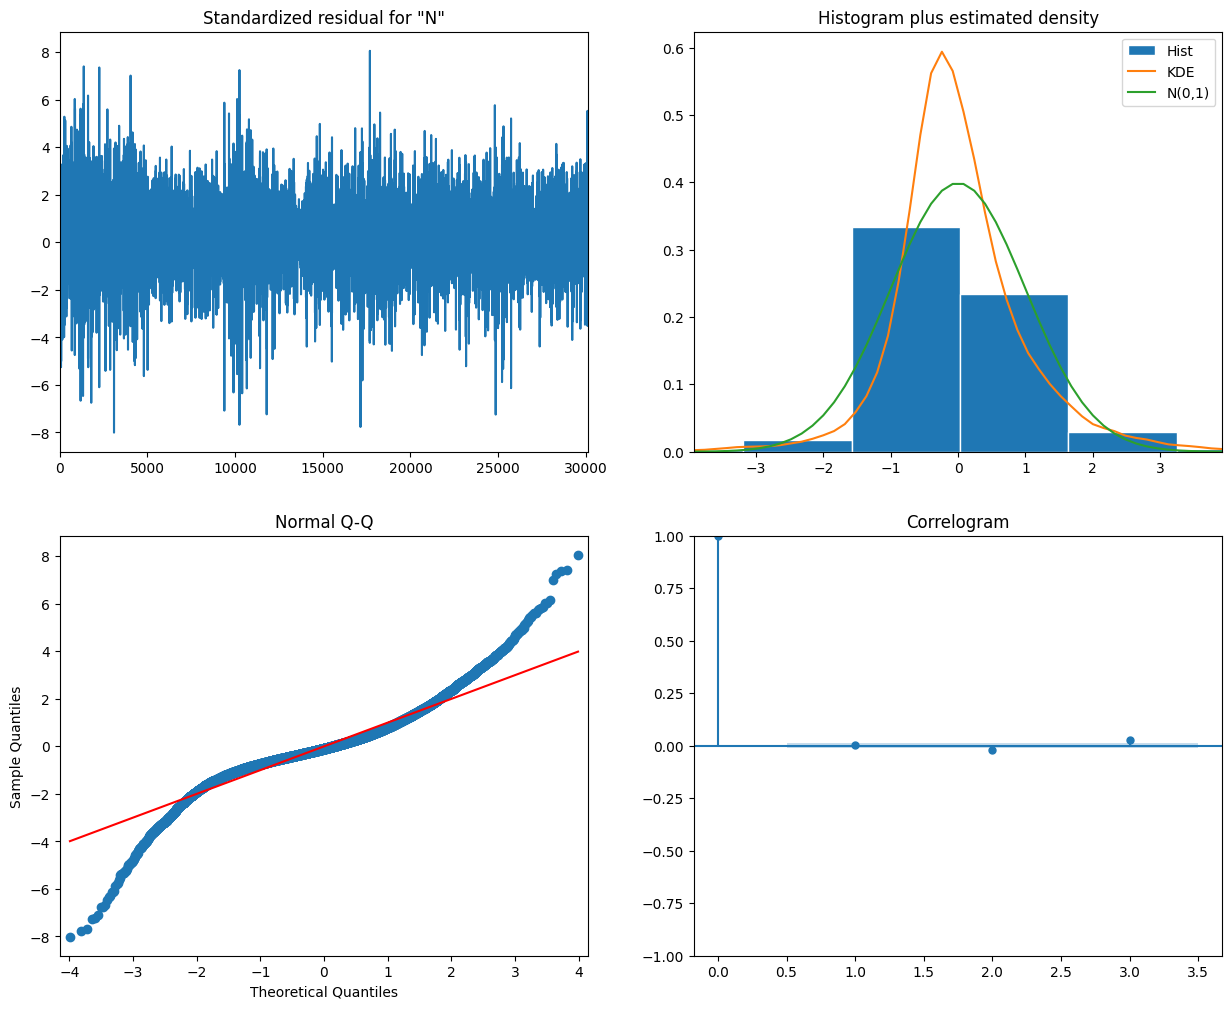

In [15]:
results.plot_diagnostics(figsize = (15, 12), lags = 3);

Interprentado los gráficos podemos observar lo siguiente:

    Arriba a la izquiera: los residuos del modelo parece que siguen un proceso de Ruido Blanco (White Noise) y no son predecibles. Esto implica que nuestro modelo ha extraído toda la información de los datos.
    Arriba a la derecha: vemos que la distribución de los residuos sigue una distribución próxima a la Normal (0, 1).
    Abajo a la derecha: vemos que la autocorrelación parcial entre los residuos y residuos - k, dan lugar a valores no significativos. Esto implica que no "nos queda" información a extraer de los residuos, es decir el modelo no ha sido capaz de reproducir el patrón de comportamiento sistemático de la serie y habría que reformularlo.
    Abajo a la izquierda: la distrbución ordenada de los residuos sigue una Normal.

## 5. Predicción utilizando el modelo

In [16]:
prediction = results.predict(start=len(df), end=len(df) + 719)
prediction

30860    36.367258
30861    36.367258
30862    36.367258
30863    36.367258
30864    36.367258
           ...    
31575    36.367258
31576    36.367258
31577    36.367258
31578    36.367258
31579    36.367258
Name: predicted_mean, Length: 720, dtype: float64

In [17]:
prediction_index = pd.date_range(start=df.index[-1], periods=720, freq='H')  # Ajusta la frecuencia 'H' según tus datos
prediction_index

DatetimeIndex(['2023-05-31 23:00:00', '2023-06-01 00:00:00',
               '2023-06-01 01:00:00', '2023-06-01 02:00:00',
               '2023-06-01 03:00:00', '2023-06-01 04:00:00',
               '2023-06-01 05:00:00', '2023-06-01 06:00:00',
               '2023-06-01 07:00:00', '2023-06-01 08:00:00',
               ...
               '2023-06-30 13:00:00', '2023-06-30 14:00:00',
               '2023-06-30 15:00:00', '2023-06-30 16:00:00',
               '2023-06-30 17:00:00', '2023-06-30 18:00:00',
               '2023-06-30 19:00:00', '2023-06-30 20:00:00',
               '2023-06-30 21:00:00', '2023-06-30 22:00:00'],
              dtype='datetime64[ns]', length=720, freq='H')

In [18]:
prediction_df = pd.DataFrame({'FECHA': prediction_index, 'Prediccion_ICA': prediction})
prediction_df.set_index('FECHA', inplace=True)
prediction_df


,Prediccion_ICA
FECHA,
2023-05-31 23:00:00,36.367258
2023-06-01 00:00:00,36.367258
2023-06-01 01:00:00,36.367258
2023-06-01 02:00:00,36.367258
2023-06-01 03:00:00,36.367258
...,...
2023-06-30 18:00:00,36.367258
2023-06-30 19:00:00,36.367258
2023-06-30 20:00:00,36.367258


## 6. Visualización de la predicción

In [19]:
plt.figure(figsize=(15, 7))
plt.plot(df['ICA'], label='Datos originales')
plt.plot(prediction_df['Prediccion_ICA'], label='Predicción')
plt.title('Predicción del ICA utilizando ARIMA')
plt.xlabel('Fecha')
plt.ylabel('ICA')
plt.legend()
plt.show()


KeyError: 'ICA'

<Figure size 1500x700 with 0 Axes>